# Flight Condition Normalization 

Following the ideas from: [Remaining Useful Life Prediction of Aircraft Engines with Variable Length Input Sequences](https://papers.phmsociety.org/index.php/phmconf/article/view/3108) PHM2021 data challenge competition winner

In [ ]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import joblib
import torch
import torch.nn as nn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from skorch import NeuralNetRegressor
from skorch.callbacks import EarlyStopping, Checkpoint

from src.pipelines.ocnorm import EstimationPipeline,HealthIndexTransformer, OperCondResidualAggregator, to_float32
from src.models.operating_condition_mlp import OperatingConditionMLP
from src.helpers.seed import set_global_seed


## Configuration

In [2]:
SEED = 42
data_name = "DS03"

In [3]:
# Paths
experiment_dir = Path('experiments')/data_name
opcond_dir = experiment_dir/'opcond'
checkpoint_dir = opcond_dir/'checkpoints'



opcond_cols = ["alt", "Mach", "TRA", "T2", "Fc", "pos"]
num_cols = ["alt", "Mach", "TRA", "T2", "pos"]
performance_cols = ["T48", "SmFan", "SmLPC", "SmHPC"]

unit_col = "unit"
cycle_col = "cycle"
hs_col = "hs"

device = "cuda" if torch.cuda.is_available() else "cpu"
os.makedirs(checkpoint_dir, exist_ok=True)

In [4]:
set_global_seed(SEED)

## 1. Load dataset

In [5]:
df = pd.read_csv(experiment_dir/'data_dev.csv',dtype={"Fc": str})
df.T

,0,1,2,3,4,5,6,7,8,9,...,557121,557122,557123,557124,557125,557126,557127,557128,557129,557130
index,0,10,20,30,40,50,60,70,80,90,...,5571185,5571195,5571205,5571215,5571225,5571235,5571245,5571255,5571265,5571275
alt,3009.0,3097.0,3179.0,3260.0,3346.0,3435.0,3524.0,3605.0,3682.0,3752.0,...,3467.0,3425.0,3385.0,3334.0,3278.0,3219.0,3163.0,3109.0,3060.0,3007.0
Mach,0.307251,0.313299,0.318969,0.32382,0.328608,0.333459,0.338373,0.342279,0.347445,0.350847,...,0.275625,0.274365,0.276003,0.276444,0.276255,0.27909,0.279216,0.279972,0.279594,0.278397
TRA,81.122467,81.122467,81.122467,81.122467,80.946686,80.946686,82.001366,76.640076,75.936958,75.936958,...,30.84939,30.84939,33.134529,31.200951,31.200951,31.11306,31.11306,31.11306,31.11306,31.11306
T2,517.529644,517.592118,517.656203,517.67799,517.681309,517.682412,517.692232,517.665854,517.744955,517.729357,...,513.997854,514.080713,514.317702,514.525963,514.718351,515.093744,515.302046,515.540115,515.695979,515.819934
T24,623.26624,623.2927,623.32745,623.3295,623.1273,623.1761,623.9616,619.19434,618.3964,618.3588,...,570.40533,570.5161,573.1398,571.358,571.5762,571.8679,572.1039,572.359,572.5353,572.69104
T30,1504.1445,1503.8613,1503.6354,1503.3647,1502.3925,1502.1003,1505.3027,1485.4314,1482.5731,1482.2891,...,1282.0638,1282.3358,1294.1842,1284.9984,1285.457,1285.6836,1286.1594,1286.6622,1287.0536,1287.424
T48,1922.4402,1921.782,1921.2112,1920.5135,1918.7623,1917.5056,1924.4946,1884.7402,1880.4617,1879.85,...,1542.0564,1542.3578,1564.4635,1546.6641,1547.2122,1547.1355,1547.6107,1548.251,1548.7966,1549.2356
T50,1306.5045,1305.6849,1304.9423,1304.114,1302.8794,1301.5067,1304.7941,1284.5435,1282.7267,1282.0399,...,1155.3447,1155.6266,1164.8433,1157.6667,1158.1072,1158.2384,1158.6005,1159.0758,1159.5267,1159.92
P15,19.479847,19.463556,19.44951,19.43104,19.397814,19.378447,19.407053,19.089066,19.029158,19.009296,...,16.13315,16.15211,16.311417,16.23702,16.269758,16.315649,16.350014,16.386671,16.414255,16.440035


## Operation Condition Normalization Procedure

Learn $f: X\mapsto Y$ frp, the flight conditions $X$ to the sensor outputs/performance metrics $Y$

$X$ Consist of 6 features, 4 flight conditions, 
* flight mach number (mach)
* altitude (alt)
* throttle resolve angle (TRA) 
* total fan inlet temperature (T2)
* flight class, a categorical feature describing the  flight length(Fc)
* positional variable of time elapsed within the flight cycle (pos)

**Note:** The paper says 5 features but they enumerate 6. 

* Performance metrics: $T48$, $SmFan$, $SmLPC$, $SmHPC$

## Train

## OC normalization pipeline (learns nominal behavior)

In [6]:
input_dim = len(num_cols) + df["Fc"].nunique()
output_dim = len(performance_cols)

callbacks = [
    EarlyStopping(
        monitor="valid_loss",
        patience=10,
        threshold=1e-4,
    ),
	Checkpoint(
    monitor="valid_loss_best",
    f_params=str(checkpoint_dir/"best_model.pt"),
    f_optimizer=str(checkpoint_dir/"best_optimizer.pt"),
    f_history=str(checkpoint_dir/"history.json"),
    f_criterion=str(checkpoint_dir/"criterion.pt"),
)]

oc_net = NeuralNetRegressor(
    OperatingConditionMLP,
    module__input_dim=input_dim,
    module__output_dim=output_dim,
    max_epochs=100,
    lr=5e-4,
    optimizer=torch.optim.AdamW,
    optimizer__weight_decay=1e-3,
    criterion=nn.MSELoss,
    iterator_train__shuffle=True,
    device=device,
    callbacks=callbacks,
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), ["Fc"]),
    ],
    remainder="drop",   # or "passthrough" if needed
)

oc_pipe = Pipeline([
    ("preprocess", preprocess),
    ("to_float32", FunctionTransformer(to_float32)),
    ("mlp", oc_net),
])

In [7]:
residual_aggregator = OperCondResidualAggregator(
        oc_pipe=None,
        opcond_cols=opcond_cols,
        perform_cols=performance_cols,
        unit_col=unit_col,
        cycle_col=cycle_col,
    )
hi_transformer=HealthIndexTransformer(
        metrics=performance_cols,
        cycle_col=cycle_col,
        q_low=0.01,
        q_high=0.99,
        corr_thresh=0.6,
    )

full_pipe = EstimationPipeline(
    oc_pipe,
    residual_aggregator,
    hi_transformer,
    hs_col=hs_col,
)


full_pipe.fit(df)

  epoch    train_loss    valid_loss    cp     dur
-------  ------------  ------------  ----  ------
      1    77002.2645      461.3045     +  1.3444
      2      202.8641       59.4732     +  1.0029
      3       46.4047       24.9194     +  0.9410
      4       20.5297       15.2257     +  0.9427
      5       12.6470       10.5885     +  0.9563
      6        8.4076        7.6064     +  0.9960
      7        5.8065        4.7062     +  0.9535
      8        3.7458        3.1853     +  0.9510
      9        2.6835        2.5278     +  0.9816
     10        1.9941        1.7143     +  0.9709
     11        1.5831        1.2019     +  0.9781
     12        1.3118        1.3611        0.9496
     13        1.1829        1.3751        0.9884
     14        1.0940        0.8479     +  0.9447
     15        1.0321        0.9924        0.9363
     16        1.0160        0.9839        0.9672
     17        0.9921        1.1811        0.9314
     18        0.9805        0.8616        0.9370


,oc_pipe,Pipeline(step...tart=False))])
,residual_aggregator,"OperCondResid...PC', 'SmHPC'])"
,hi_transformer,"HealthIndexTr...PC', 'SmHPC'])"
,hs_col,'hs'
,metrics,"['T48', 'SmFan', ...]"
,cycle_col,'cycle'
,q_low,0.01
,q_high,0.99
,corr_thresh,0.6
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'


## Save the pipeline 

In [8]:
joblib.dump(full_pipe, opcond_dir/"pipeline_best.joblib")

['experiments/DS03/opcond/pipeline_best.joblib']

## Load the pipeline

In [9]:
pipe:EstimationPipeline = joblib.load(opcond_dir/"pipeline_best.joblib")
pipe.set_bounds(df,q_low=0.01, q_high=0.99)
df_hi = pipe.transform(df)

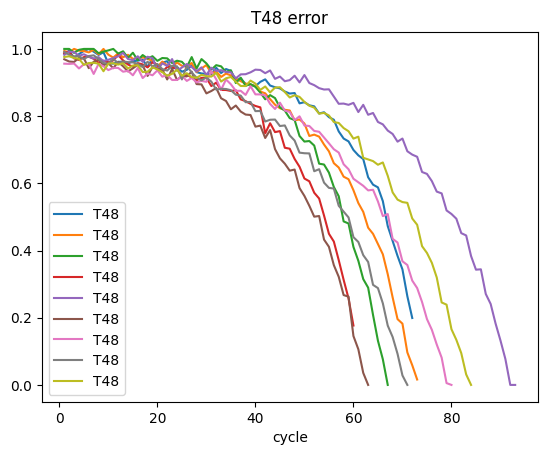

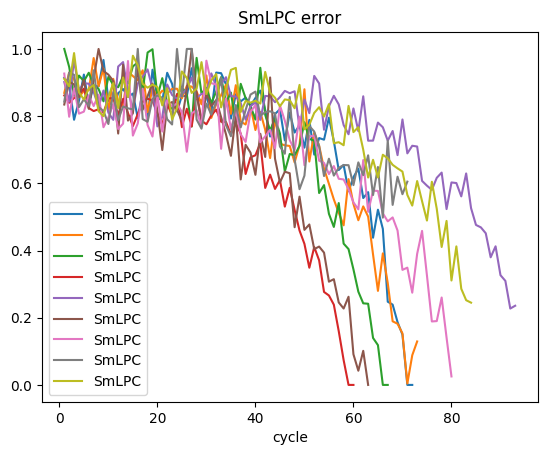

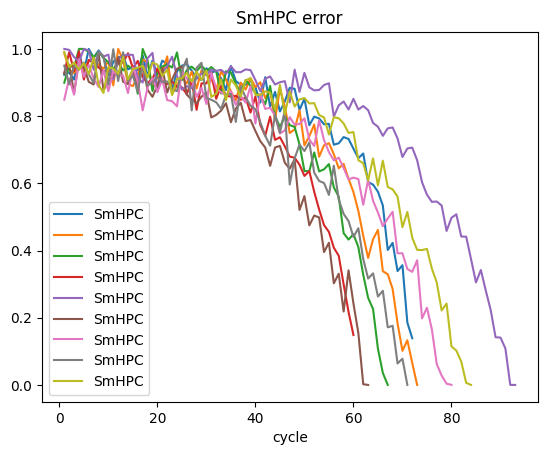

In [10]:
for perf in pipe.get_performances():
    fig, ax = plt.subplots()
    ax.set_title(f"{perf} error")
    df_hi.groupby("unit").plot(x="cycle", y=f'{perf}', ax=ax, legend=True)